In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV # Линейна регрессия, Ридж и Лассо
from sklearn.linear_model import LassoCV, RidgeCV, MultiTaskLassoCV # Ridge и Lasso Регрессия
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import make_scorer, r2_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column',None) 
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

c:\Users\sobak\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("data.csv")

In [4]:
df

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
0,50.074285,50.656771,500.475537,1207.542773,912.161426,119.562970,51.248955
1,50.074926,50.656771,500.379883,1209.190723,914.203027,119.683643,51.255357
2,50.074836,50.666920,499.359570,1210.159082,914.924512,119.665576,51.263570
3,50.074957,50.666920,500.535840,1210.641602,915.881055,119.674750,51.267725
4,50.075145,50.666920,500.198145,1211.398438,916.435645,119.692188,51.264826
...,...,...,...,...,...,...,...
29707,50.070496,52.706500,459.827393,1238.176660,914.571973,128.579962,51.102349
29708,50.070217,52.716716,459.400806,1237.532422,913.476074,128.521655,51.102543
29709,50.070292,52.696284,459.942578,1237.783984,913.913086,128.503632,51.102639
29710,50.070389,52.675853,460.185791,1237.441895,913.895508,128.481744,51.103799


In [5]:
inputs = ['KS4_GPA5_Qtg.PV', 'KS4_GPA5_TC_T1.PV', 'KS4_GPA5_Nst.PV']
outputs = ['KS4_GPA5_Nvd.PV', 'KS4_GPA5_Nnd.PV', 'KS4_GPA5_T4.PV', 'KS4_GPA5_Pk.PV']

# Задача - построить предсказательую модель outputs по inputs
### Результатом решения задачи является код эксперимента в Jupyter Notebook, содержащий качественное обоснование выбора той или иной архитектуры (метода). В качестве base line рекомендуется выбрать модель линейной регрессии. 

# ДЗ: 
1. Сделать разведочный анализ данных, найти пропуски и выбросы. Примеры есть в ноутбуке EDA_AUTO из 4 задания.
2. Заполнить пропуски. Заполнить медианой или обучить линейную регрессию и заполнить ею пропуски. Если заполните линейной регрессией пропуски, то с помощью таблицы корреляций найдите второй признак, который имеет сильную взаимосвязь с первым признаком. Создаете отдельный датафрейм из этих признаков, исключаете пропуски (не удаляете), обучаете линейну регрессию. Затем прогнозируете на исключенных данных с пропусками и заполняете эти пропуски предсказанным значением.
3. Обучить множественную линейную регрессию. Она будет являться base line, т.е. базовая модель. С ней вы будете сравнивать другие модели.
4. Используя кроссвалидацию, подбор гиперпараметров обучить модели Lasso regression, Ridge Regression, ElasticNet (модель где Ridge + Lasso вместе используется), DecisionTreeRegressor, SVR, RandomForestRegressor

5. `alphas=[0.0001, 0.001,0.01, 0.1, 1, 10]` - для MultiTaskLassoCV, RidgeCV, и для ElasticNetCV.

`'l1_ratio':[0.01, 0.1, 0.5, 1, 5, 10, 15, 20]` - для ElasticNetCV

6. **для SVR и RandomForest:**
```python
param_grid = [{'regressor':[SVR()], 'preprocessing':[StandardScaler(), None],
              'regressor__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'regressor': [DecisionTreeRegressor()],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]},
              {'regressor': [RandomForestRegressor(n_estimators=100)],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]}]
```

7. **Если SVR обучается, то используем только этот набор параметров:**
```python
param_grid={
    'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01],
}
```

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29712 entries, 0 to 29711
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   KS4_GPA5_Qtg.PV    29712 non-null  float64
 1   KS4_GPA5_TC_T1.PV  29712 non-null  float64
 2   KS4_GPA5_Nst.PV    29712 non-null  float64
 3   KS4_GPA5_Nvd.PV    29712 non-null  float64
 4   KS4_GPA5_Nnd.PV    27711 non-null  float64
 5   KS4_GPA5_T4.PV     29712 non-null  float64
 6   KS4_GPA5_Pk.PV     29712 non-null  float64
dtypes: float64(7)
memory usage: 1.6 MB


In [7]:
df.isnull().sum()

KS4_GPA5_Qtg.PV         0
KS4_GPA5_TC_T1.PV       0
KS4_GPA5_Nst.PV         0
KS4_GPA5_Nvd.PV         0
KS4_GPA5_Nnd.PV      2001
KS4_GPA5_T4.PV          0
KS4_GPA5_Pk.PV          0
dtype: int64

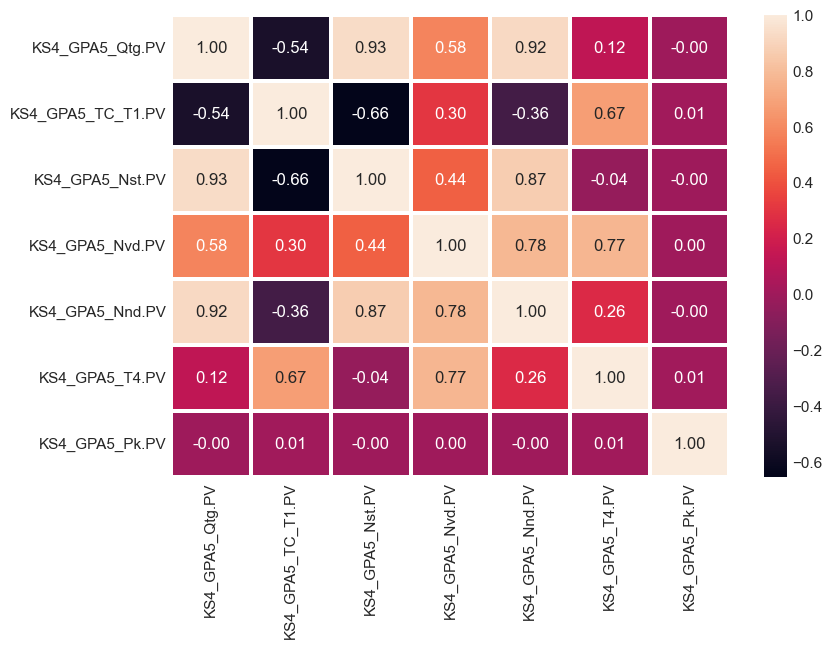

In [8]:
corr = df.corr()
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

In [9]:
column_list = df.columns

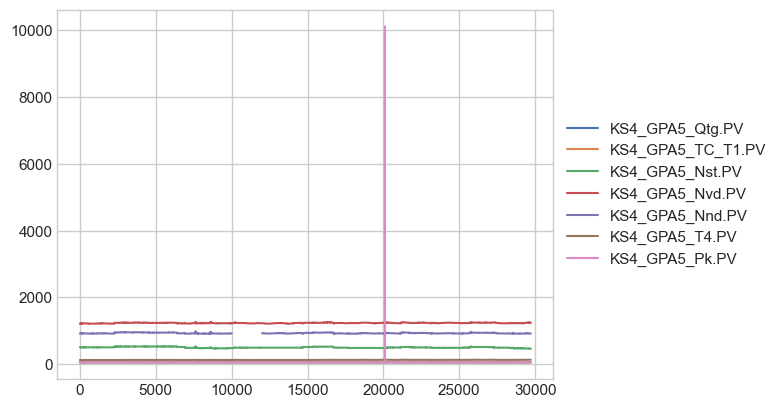

In [10]:
ax = df[column_list].plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

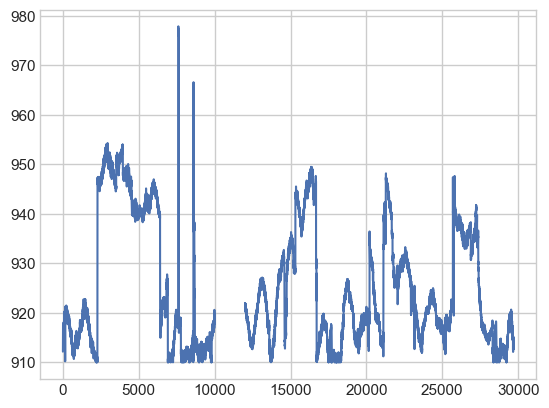

In [12]:
# пропуск в KS4_GPA5_Nnd.PV
ax_nnd=df['KS4_GPA5_Nnd.PV'].plot()

In [13]:
# заполнение пропуска
df['KS4_GPA5_Nnd.PV'] = df['KS4_GPA5_Nnd.PV'].interpolate()

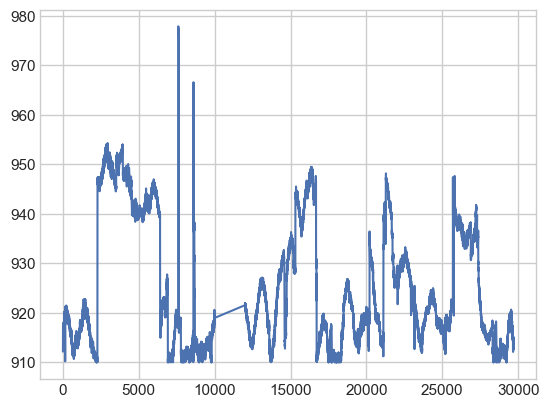

In [14]:
ax_nnd_filled=df['KS4_GPA5_Nnd.PV'].plot()

In [15]:
# проверка заполнения
df['KS4_GPA5_Nnd.PV'].isnull().sum()

0

In [16]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [17]:
df_outliers = find_outliers_IQR(df)
df_outliers[df_outliers.notnull().any(1)]

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
7604,NaN,NaN,NaN,1257.809570,968.497168,NaN,NaN
7605,NaN,NaN,NaN,1263.410352,976.965234,NaN,NaN
7606,NaN,NaN,NaN,1263.102832,976.558203,NaN,NaN
7607,NaN,NaN,NaN,1263.996680,977.826953,NaN,NaN
7608,NaN,NaN,NaN,1263.961133,977.067090,NaN,NaN
...,...,...,...,...,...,...,...
8607,NaN,NaN,NaN,1264.058203,966.545801,NaN,NaN
8608,NaN,NaN,NaN,1263.088770,965.224023,NaN,NaN
8609,NaN,NaN,NaN,1262.818750,964.658594,NaN,NaN
8610,NaN,NaN,NaN,1258.684082,NaN,NaN,NaN


In [18]:
df_outliers.notnull().sum()

KS4_GPA5_Qtg.PV       0
KS4_GPA5_TC_T1.PV     0
KS4_GPA5_Nst.PV       0
KS4_GPA5_Nvd.PV      43
KS4_GPA5_Nnd.PV      40
KS4_GPA5_T4.PV        0
KS4_GPA5_Pk.PV        1
dtype: int64

In [20]:
df = df.drop(df[df['KS4_GPA5_Pk.PV'] > 10000].index)

In [21]:
df_outliers = find_outliers_IQR(df)
df_outliers.notnull().sum()

KS4_GPA5_Qtg.PV       0
KS4_GPA5_TC_T1.PV     0
KS4_GPA5_Nst.PV       0
KS4_GPA5_Nvd.PV      43
KS4_GPA5_Nnd.PV      40
KS4_GPA5_T4.PV        0
KS4_GPA5_Pk.PV        0
dtype: int64

In [25]:
X = df[inputs]
y = df[outputs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Score: {r2_score(y_test, y_pred)}')

Score: 0.8832778435328518


In [43]:
param_grid={"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]}
lasso_search = GridSearchCV(Lasso(), param_grid,cv=5, n_jobs=-1)
lasso_search.fit(X_train, y_train)
print('Lasso GridSearch results:')
print(f'   Best params: {lasso_search.best_params_}')
print(f'   Best score: {lasso_search.best_score_}')
print(f'   Train score: {lasso_search.score(X_train, y_train)}')
print(f'   Test score: {lasso_search.score(X_test, y_test)}')

Lasso GridSearch results:
   Best params: {'alpha': 0.0001}
   Best score: 0.8775214882566418
   Train score: 0.8777179037053248
   Test score: 0.8788614582160146


In [44]:
ridge_search = GridSearchCV(Ridge(), param_grid,cv=5,n_jobs=-1)
ridge_search.fit(X_train, y_train)
print('Ridge GridSearch results:')
print(f'   Best params: {ridge_search.best_params_}')
print(f'   Best score: {ridge_search.best_score_}')
print(f'   Train score: {ridge_search.score(X_train, y_train)}')
print(f'   Test score: {ridge_search.score(X_test, y_test)}')

Ridge GridSearch results:
   Best params: {'alpha': 0.0001}
   Best score: 0.8817516918586156
   Train score: 0.8819535287658632
   Test score: 0.8832775246548008


In [53]:
param_grid_elasticnet = param_grid.copy()
param_grid_elasticnet['l1_ratio'] = [0.01, 0.1, 0.5, 1, 5, 10, 15, 20]
elasticnet_search = GridSearchCV(ElasticNet(), param_grid_elasticnet, cv=5,n_jobs=-1)
elasticnet_search.fit(X_train, y_train)
print('ElasticNet GridSearch results:')
print(f'   Best params: {elasticnet_search.best_params_}')
print(f'   Best score: {elasticnet_search.best_score_}')
print(f'   Train score: {elasticnet_search.score(X_train, y_train)}')
print(f'   Test score: {elasticnet_search.score(X_test, y_test)}')

ElasticNet GridSearch results:
   Best params: {'alpha': 0.0001, 'l1_ratio': 1}
   Best score: 0.8775214882566418
   Train score: 0.8777179037053248
   Test score: 0.8788614582160146


In [49]:
param_grid_dt = {'max_features': [1, 2, 3]}
decision_tree_search = GridSearchCV(DecisionTreeRegressor(), param_grid_dt,cv=5,n_jobs=-1)
decision_tree_search.fit(X_train, y_train)
print('Decision Tree GridSearch results:')
print(f'   Best params: {decision_tree_search.best_params_}')
print(f'   Best score: {decision_tree_search.best_score_}')
print(f'   Train score: {decision_tree_search.score(X_train, y_train)}')
print(f'   Test score: {decision_tree_search.score(X_test, y_test)}')

Decision Tree GridSearch results:
   Best params: {'max_features': 3}
   Best score: 0.9860892076764047
   Train score: 1.0
   Test score: 0.9871305312313919


In [51]:
from sklearn.multioutput import MultiOutputRegressor
param_grid_svr = {
    'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01],
}
svr = SVR()
multioutput_svr = MultiOutputRegressor(svr)
svr_search = GridSearchCV(multioutput_svr, param_grid_svr,cv=3,n_jobs=-1)
svr_search.fit(X_train, y_train)
print('SVR GridSearch results:')
print(f'   Best params: {svr_search.best_params_}')
print(f'   Best score: {svr_search.best_score_}')
print(f'   Train score: {svr_search.score(X_train, y_train)}')
print(f'   Test score: {svr_search.score(X_test, y_test)}')

SVR GridSearch results:
   Best params: {'estimator__C': 0.01, 'estimator__gamma': 0.01}
   Best score: 0.48659832030880934
   Train score: 0.5199464887201992
   Test score: 0.5178920443870717


In [52]:
param_grid_rf = {'max_features': [1, 2, 3]}
random_forest_search = GridSearchCV(DecisionTreeRegressor(), param_grid_rf,cv=5,n_jobs=-1)
random_forest_search.fit(X_train, y_train)
print('Random Forest GridSearch results:')
print(f'   Best params: {random_forest_search.best_params_}')
print(f'   Best score: {random_forest_search.best_score_}')
print(f'   Train score: {random_forest_search.score(X_train, y_train)}')
print(f'   Test score: {random_forest_search.score(X_test, y_test)}')

Random Forest GridSearch results:
   Best params: {'max_features': 3}
   Best score: 0.9861800984086567
   Train score: 1.0
   Test score: 0.9870291715205758


 ### Результаты моделей на тестовых данных:
 #### 1. Decision Tree 0.9871305312313919
 #### 2. Random Forest 0.9870291715205758
 #### 3. LinearRegression 0.8832778435328518
 #### 4. Ridge 0.8832775246548008
 #### 5. ElasticNet 0.8788614582160146
 #### 6. Lasso 0.8788614582160146
 #### 7. SVR 0.5178920443870717